In [1]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
from collections import Counter
import os
from scipy.stats import pearsonr
from scipy.spatial.distance import braycurtis
from sklearn.metrics import r2_score
from statannot import add_stat_annotation
from scipy.stats import spearmanr
%matplotlib inline

# Read taxonomy

In [2]:
df_tax = pd.read_csv('qiime2_output/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy
0,668fdb718997fc1589c7817655d4bb5f,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides
1,4bf3198c78397be5af0b7325d20558de,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.999993,g__Prevotella
2,c1dc9ad5116d96b8ed863458fc0d0aec,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.944837,g__Blautia
3,a7a1a93ecfcef4cb45b42307a4fa3bca,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides
4,a3f36ef32153f2fc2aaeac2feb23777f,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.998179,g__Faecalibacterium


# Read metadata

In [3]:
df_meta = pd.read_csv("qiime2_output/SraRunTable.txt", index_col=0)
df_meta = df_meta[['Sample Name','timepoint']]
df_meta.columns = ['SampleName','Timepoint']
df_meta['Disease'] = [x.split('.SPA')[0] if 'SPA' in x else x.split('.')[0] for x in df_meta.SampleName]
df_meta['Disease2'] = ['H' if x.startswith('H') else x for x in df_meta.Disease]
df_meta.head()

,SampleName,Timepoint,Disease,Disease2
Run,,,,
SRR6463006,UC.SPA.4.5,Last,UC,UC
SRR6463007,UC.SPA.4.4,Interval,UC,UC
SRR6463008,H.CD.SPA.24.0,Basal,H.CD,H
SRR6463009,H.CD.SPA.24.1,Last,H.CD,H
SRR6463010,H.CD.SPA.16.1,Last,H.CD,H


In [4]:
set(df_meta.Disease)

{'CD', 'H', 'H.CD', 'H.UC', 'UC'}

In [5]:
set(df_meta.Disease2)

{'CD', 'H', 'UC'}

# Read count data (filter out samples with less than 1000 reads)

In [6]:
df_count = pd.read_csv('qiime2_output/feature-table/feature-table.from_biom.txt', sep="\t", index_col=0, skiprows=[0])
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_meta.index).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum total count = 7749


#OTU ID,668fdb718997fc1589c7817655d4bb5f,4bf3198c78397be5af0b7325d20558de,c1dc9ad5116d96b8ed863458fc0d0aec,a7a1a93ecfcef4cb45b42307a4fa3bca,a3f36ef32153f2fc2aaeac2feb23777f,1b158b8b2922d4fcad5d9cea607cbb7d,2d34c22edce4b1f2d8a5228ad78f8ea8,9496d87b94d90dff068f0716603930bd,cc2d96099f530b503371e5ddca8c0a58,c3bdda568b2c1580d5cce7407ef43909,...,42796205bc53854d75ce0a7574236eb0,cbe2acd309b9678bca717fe665d0a44e,6faf2424842843ad49d2695c6c6d0517,ebac86533f670e77e878a40b7a43fdcc,a7279c95f5bbfe8a9fd17ccc04971010,75db3fd63b03bbcb45753a80884a2b10,11ce2c7eb78bc94549463d19700b4900,19c53f45d3635acb09a269b1c6ffbdb5,cb8a46271d394b5b277bcc180861e99a,aedebdb40ec091f808183ef59c9a6f96
SRR6463032,0.000000,0.000000,0.100594,0.002992,0.000000,0.010156,0.000000,0.00000,0.012124,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR6463202,0.002475,0.398843,0.004664,0.000000,0.003960,0.000234,0.000417,0.00000,0.000000,0.003778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR6463384,0.019087,0.000000,0.007263,0.037020,0.020313,0.000000,0.068327,0.00000,0.000000,0.021772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR6463317,0.056755,0.000000,0.014363,0.006720,0.014547,0.000553,0.033561,0.00000,0.000000,0.012273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR6463099,0.342967,0.000161,0.079740,0.000000,0.000000,0.040272,0.000000,0.04319,0.081463,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Compare different oral fraction estimation methods

In [7]:
df_blast_HMPv35oral = pd.read_csv("qiime2_output/asv-sequences/blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_HMPv35oral.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_oral = df_relabun[set(df_relabun.columns).intersection(set(df_blast_HMPv35oral.query_accver))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1)
df_meta_oral = pd.merge(df_meta, df_oral, left_index=True, right_index=True, how='inner')
df_meta_oral['log10_OralFrac'] = np.log10(df_meta_oral['OralFrac'])
df_meta_oral.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,SampleName,Timepoint,Disease,Disease2,OralFrac,log10_OralFrac
SRR6463006,UC.SPA.4.5,Last,UC,UC,0.000775,-3.110590
SRR6463007,UC.SPA.4.4,Interval,UC,UC,0.001190,-2.924495
SRR6463008,H.CD.SPA.24.0,Basal,H.CD,H,0.003517,-2.453859
SRR6463009,H.CD.SPA.24.1,Last,H.CD,H,0.001684,-2.773786
SRR6463010,H.CD.SPA.16.1,Last,H.CD,H,0.084483,-1.073232


In [8]:
Counter(df_meta_oral.Disease)

Counter({'UC': 129, 'H.CD': 64, 'CD': 140, 'H.UC': 46, 'H': 44})

In [9]:
Counter(df_meta_oral.Disease2)

Counter({'UC': 129, 'H': 154, 'CD': 140})

In [10]:
len(df_meta_oral)

423

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

H v.s. CD: Welch's t-test independent samples, P_val=2.619e-03 stat=-3.040e+00
H v.s. UC: Welch's t-test independent samples, P_val=1.062e-04 stat=-3.937e+00


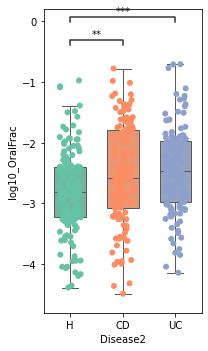

In [16]:
fig, ax = plt.subplots(figsize=(3,5))

df_meta_oral2 = df_meta_oral[df_meta_oral.OralFrac>0]
_ = sns.boxplot(y="log10_OralFrac", x="Disease2", data=df_meta_oral2, width=.6, ax=ax, order=['H','CD','UC'], palette='Set2', linewidth=1, showfliers=False)
_ = sns.stripplot(y="log10_OralFrac", x="Disease2", data=df_meta_oral2, size=6, color=".3", linewidth=0, ax=ax, jitter=0.2, palette='Set2', dodge=True, order=['H','CD','UC'])
_ = add_stat_annotation(ax, data=df_meta_oral2, y="log10_OralFrac", x="Disease2", order=['H','CD','UC'],
                        comparisons_correction=None,
                        box_pairs=[("H","CD"),("H","UC")],
                        test='t-test_welch', text_format='star', loc='outside', verbose=1)
_ = ax.set_ylim([-4.8,0.2])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("Comparison_HC_UC_CD.svg", dpi=600)